## Data preprocessing

Let's start off by preprocessing our data.
Just run the code, it will download the dataset and do all the things for you.
We have a table of movies which includes genres and tags. Tags stored as another table that has relevances associated with each tag. The main idea I imply here is that I sort tag by -relevance (in descending order) and put them in string. Then I split the genres (which are listed separated by |) and prepend them to the start of the line.
Just run the code and see the final table, nothing profusely educating here.

**Note from the future:** I tried using pandas with pytorch data-loaders and it worked super slow and it doesn't stand a chance in the production-grade applications. It took seconds to form batches, even though I used dictionaries for interaction history with userIds as the keys. The movie themselves were stored in the torch.tensor that has was saved and loaded constantly. It didn't work at all and was literally crawling. Let's try a different approach using HDF5, hoping that it will work out.

**ATTENTION:** This is kind of computationally expensive so I you do not have a GPU, you can download the dataset from my [google drive](https://drive.google.com/open?id=1mzqM33HnFBYXnjBevzade6rd0sPG60y8)

The code below will download the dataset and unpack it.

In [31]:
import zipfile
import wget
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm

files = dict()
url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'  
path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
zippath = os.path.join(path, 'ml-20m.zip')
if not os.path.isfile(zippath):
    wget.download(url, path)
    zip_ref = zipfile.ZipFile(zippath, 'r')
    zip_ref.extractall(path)
    zip_ref.close()
path = os.path.join(path, 'ml-20m')
print('reading csv:', os.listdir(path))
for file in tqdm(os.listdir(path)):
        if file.endswith('.csv') and file.split('.') != 'ratings':
            files[file.split('.')[0]] = pd.read_csv(os.path.join(path, file))

reading csv: ['genome-scores.csv', 'genome-tags.csv', 'links.csv', 'movies.csv', 'ratings.csv', 'README.txt', 'tags.csv']


In [39]:
def reverse_respect_sort(X, Y):
    return list(reversed([x for _, x in sorted(zip(Y,X), key=lambda pair: pair[0])]))

def get_tags(t, max_tags):
    tags = dict()
    tags['relevance'] = t['relevance'].tolist()
    tags['tag'] = t['tag'].tolist()

    tags = reverse_respect_sort(tags['tag'], tags['relevance'])[:max_tags]
    tags = ' '.join(tags)
    return tags

def data_processor(files):
    files['user-tags'] = files['tags']
    files['tags'] = files['genome-scores'].merge(files['genome-tags'], left_on='tagId',
                                                   right_on='tagId', how='inner')
    del files['genome-scores']
    del files['genome-tags']
    del files['links']
    files['tags'] = files['tags'].sort_values(by=['movieId', 'tagId']).reset_index(drop=True)
    # files['ratings'] = files['ratings'].sort_values(by=['userId', 'timestamp']).reset_index(drop=True)
    
    titles = files['movies']['title'].map(lambda s: s[:s.find("(")])
    
    del files['movies']['title']
    files['movies']['title'] = titles
    return files

files = data_processor(files)

## Word Encoding
It's time for us to encode the words. I am going to use Google's BERT for this. 
Here is a quick explanation of what I am doing:
First I collect all the tags scattered around the tags.csv file, then I merge them with genres and titles into one big line which I fit into Google's BERT. May be a bit overkill, but I think it's worth the cost. By the way, if you don't have a GPU, the dataset is available to download on my [google drive](https://drive.google.com/open?id=1mzqM33HnFBYXnjBevzade6rd0sPG60y8). The end result is n_films x 768 matrix, which I store as a pytorch tensor (without HDF5).

![](../res/textdatatransformer.png )

Huge thanks to [this gist](https://gist.github.com/Tushar-N/dfca335e370a2bc3bc79876e6270099e)

In [3]:
from pytorch_pretrained_bert import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from pytorch_pretrained_bert import BertTokenizer, BertModel
cuda = torch.device('cuda')
bert = BertModel.from_pretrained('bert-base-uncased').to(cuda)
bert.eval()

all_movies_id = files['movies']['movieId'].tolist()
max_tags = 50

data_films = pd.DataFrame()

infos = []
mov_batch = []
batch_size = 16

for m in tqdm(all_movies_id):
    movie = files['movies'].loc[all_movies_id.index(m)]
    
    tags = files['tags'].loc[files['tags']['movieId'] == m]
    tags = get_tags(tags, max_tags)
    genres = ' '.join(movie['genres'].split('|'))

    total = dict()
    id = movie['movieId']
    info = movie['title'] + ' ' + genres + ' ' + tags
    info = tokenizer.tokenize(info)
    info = tokenizer.convert_tokens_to_ids(info)
    info = torch.tensor(info).to(cuda)
    mov_batch.append(info)
    
    if len(mov_batch) >= batch_size:
        seq_lengths = torch.tensor([len(seq) for seq in mov_batch]).long().cuda()
        seq_tensor = torch.zeros((len(mov_batch), seq_lengths.max())).long().cuda()
        
        for idx, (seq, seqlen) in enumerate(zip(mov_batch, seq_lengths)):
            seq_tensor[idx, :seqlen] = torch.tensor(seq).long().cuda()
            
        _, output = bert(seq_tensor)

        output = output.detach().cpu()
        infos.append(output)
        mov_batch = []

In [5]:
seq_lengths = torch.tensor([len(seq) for seq in mov_batch]).long().cuda()
seq_tensor = torch.zeros((len(mov_batch), seq_lengths.max())).long().cuda()

for idx, (seq, seqlen) in enumerate(zip(mov_batch, seq_lengths)):
    seq_tensor[idx, :seqlen] = torch.tensor(seq).long().cuda()
            
_, output = bert(seq_tensor)

output = output.detach().cpu()
infos.append(output)

In [22]:
stacked = torch.cat(infos)

In [23]:
stacked.size()

torch.Size([27278, 768])

In [24]:
torch.save(stacked, '../data/bert_emb.pt')

## AutoEncoders for Unsupervised Feature Learning

**At this point, I would highly recommend you to restart your kernel because cuda or ram is flooded with used memory.**

We kinda have movie embeddings as is right now and can move on even further, but these embeddings are not quite complete. First of all, they are big in size (being 768 features), let's shrink it down to say 32. Another thing to be taken into consideration is that they are quietly vague in that form and the difference must be extensively pointed out. Note: I am not using VAE (variational stuff) because I don't care if it overfits for the dataset is going to ba the same all the time. Principal component analysis (PCA) is primarily used for generating stuff and cool sliders and dosen't quiet apply to our task.

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

sns.set()
cuda = torch.device('cuda')

In [2]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(768, 32),
            nn.Tanh(),
            #nn.Dropout(0.3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 768),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
data = torch.load('../data/bert_emb.pt')

In [12]:
n_epochs = 20
batch_size = 128

model = AutoEncoder().to(cuda)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=10e-4)
run_loss = []

for epoch in tqdm(range(n_epochs)):
    for batch in data.split(batch_size):
        optimizer.zero_grad()
        batch = batch.to(cuda)
        output = model(batch).float()
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        run_loss.append(loss.item())

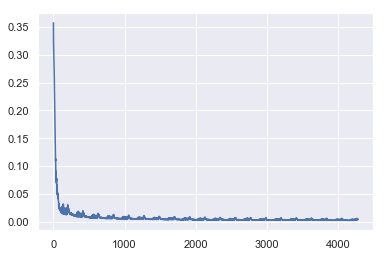

In [13]:
sns.lineplot(x=range(len(run_loss)), y=run_loss)

In [14]:
encoded = []
model.eval()

for batch in data.split(batch_size):
    batch = batch.to(cuda)
    encoded.append(model.encoder(batch))

In [15]:
encoded = torch.cat(encoded)

In [26]:
encoded.size()

torch.Size([27278, 32])

In [27]:
torch.save(encoded.detach(), '../data/enc_emb.pt')

# User Ratings with HDF5 

**Then again, restart the kernel**

Make sure you have runned the **Data preprocessing** section to load the data again.

## Ratings by user

In [4]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import h5py
import numpy as np
import multiprocessing as mp

### Multithreaded

In [2]:
ratings = pd.read_csv('../data/ml-20m/ratings.csv')
users = np.array(list(set(ratings['userId'])))
users_by_process = np.array_split(users, 4)
pbar = tqdm(total=len(users))

def process(i, users):
    ratings_by_user = dict([(i, pd.DataFrame()) for i in users])
    for u in tqdm(list(users)):
            ratings_by_user[u] = ratings.loc[ratings['userId'] == u].sort_values(by='timestamp').reset_index(drop=True)
    pbar.update(1)
    return ratings_by_user

pool = mp.Pool(processes=4)
results = [pool.apply(process, args=(i, users_by_process[i])) for i in range(4)]
ratings_by_user = pd.DataFrame()
for i in results:
    ratings_by_user = r.append(i)

### Singlethreaded

In [ ]:
ratings = pd.read_csv('../data/ml-20m/ratings.csv')
users = np.array(list(set(ratings['userId'])))
ratings_by_user = dict([(i, pd.DataFrame()) for i in users])
for u in tqdm(list(users)):
        ratings_by_user[u] = ratings.loc[ratings['userId'] == u].sort_values(by='timestamp').reset_index(drop=True)

### Reward Function

I know, I should have done it beforehand for an idiot I am. I tried to use rewards as is, but it didn't work out. So we must introduce some more distinguishable reward function. Let's assume that a healthy middle of a film's rating is somewhat 2,5. If user scored it 5/5 we have to beleive he really enjoyed it, rewarding the agent with a big positive score. On contrary, if he had scored it 0.5/5, we reward it with a big negative one.

In [ ]:
%matplotlib inline
ratings['rating'].hist()

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


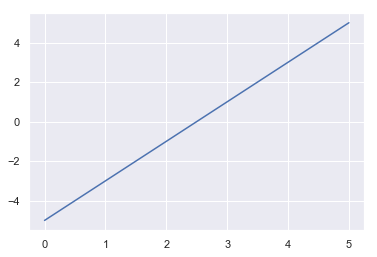

In [2]:
%matplotlib inline

import seaborn as sns
sns.set()

x = np.linspace(0, 5, num=11)
y = np.vectorize(lambda i: 2*(i-2.5))(x)

sns.lineplot(x=x, y=y)
print(x)
print(y)

### HDF5 you've been waiting for

In [5]:
import pickle

ratings_by_user = pickle.load(open('../data/rbu.pkl', 'rb'))

for user in tqdm(ratings_by_user.keys()):
    ratings_by_user[user] = ratings_by_user[user].drop(['timestamp', 'userId'], axis=1)
    ratings_by_user[user]['rating'] = ratings_by_user[user]['rating'].apply(lambda i: 2*(i-2.5))

In [7]:
for user in tqdm(list(ratings_by_user.keys())):
    ratings_by_user[user]['rating'] = ratings_by_user[user]['rating'].apply(lambda i: 2*(i-2.5))
    ratings_by_user[user] = ratings_by_user[user].values

In [9]:
pickle.dump(ratings_by_user, open('../data/rbu.pkl', 'wb'))

array([[ 9.2400e+02, -1.0000e+00],
       [ 9.1900e+02, -1.0000e+00],
       [ 2.6830e+03, -1.0000e+00],
       [ 1.5840e+03, -1.0000e+00],
       [ 1.0790e+03,  1.0000e+00],
       [ 6.5300e+02, -3.0000e+00],
       [ 2.9590e+03,  1.0000e+00],
       [ 3.3700e+02, -1.0000e+00],
       [ 1.3040e+03, -3.0000e+00],
       [ 3.9960e+03,  1.0000e+00],
       [ 1.5100e+02,  1.0000e+00],
       [ 1.1200e+02, -1.0000e+00],
       [ 1.3740e+03,  1.0000e+00],
       [ 1.2460e+03, -1.0000e+00],
       [ 1.3700e+03, -3.0000e+00],
       [ 2.2910e+03,  1.0000e+00],
       [ 4.3060e+03,  1.0000e+00],
       [ 1.2140e+03,  1.0000e+00],
       [ 1.2780e+03,  1.0000e+00],
       [ 1.2580e+03,  1.0000e+00],
       [ 1.2190e+03,  1.0000e+00],
       [ 6.2420e+03, -1.0000e+00],
       [ 4.7200e+03, -1.0000e+00],
       [ 2.7160e+03, -1.0000e+00],
       [ 2.6480e+03, -1.0000e+00],
       [ 8.5070e+03,  5.0000e+00],
       [ 1.9970e+03, -1.0000e+00],
       [ 6.5020e+03, -1.0000e+00],
       [ 1.3480e+03,

In [23]:
encoded[1][0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.8630, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.3292, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 5.9660, 1.5641, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.8052, 3.6342],
       device='cuda:0', grad_fn=<SelectBackward>)